In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

## Passo 1: Leitura dos dados
Leitura dos bancos de dados em DataFrame Pandas. 

In [2]:
caminho_dados_lazaro = 'Datasets/Lazaro/dados_pre_processados_lazaro.csv'

In [3]:
df = pd.read_csv(caminho_dados_lazaro)

In [4]:
df.head()

,Piquete,Altura real,Altura esperada,Animal,SensorID,Sensor Name,Date,X,Y,Z,Comportamento,Season_fall,Season_spring,Season_summer
0,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:47,-0.132,-0.583,0.712,Ocio,0.0,1.0,0.0
1,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:48,0.021,-0.792,0.574,Ocio,0.0,1.0,0.0
2,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:50,0.021,-0.792,0.574,Ocio,0.0,1.0,0.0
3,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:51,0.021,-0.792,0.574,Ocio,0.0,1.0,0.0
4,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:52,-0.061,-0.870,0.478,Ocio,0.0,1.0,0.0


## Passo 2: Treinamento

In [5]:
# Para a busca do melhores hiperparêmetros
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

### Criação de novas features

#### Magnitude

In [6]:
a = df[['X', 'Y', 'Z']].pow(2)

In [7]:
b = a.sum(axis=1)

In [8]:
magn = b.pow(1/2)
magn = magn.rename('magn')

In [9]:
df = pd.concat([df, magn], axis=1)

#### Signal Magnitude Area

In [10]:
a = df[['X', 'Y', 'Z']].abs()

In [11]:
sma = a.sum(axis=1)
sma = sma.rename('sma')

In [12]:
df = pd.concat([df, sma], axis=1)

#### Entropy - Não melhorou

In [377]:
a = df[['X', 'Y', 'Z']]

In [378]:
a = a.sum(axis=1)

In [379]:
a = a + 1

In [380]:
a = a.pow(2)

In [381]:
a = a.replace(to_replace=0, value=0.0001)

In [382]:
b = np.log(a)

In [383]:
ent = a*b
ent = ent.rename('ent')

In [384]:
df = pd.concat([df, ent], axis=1)

#### Energy

In [408]:
a = df[['X', 'Y', 'Z']]

In [409]:
a = a.pow(2)

In [410]:
a = a.sum(axis=1)

In [411]:
erg = a.pow(2)
erg = erg.rename('erg')

In [412]:
df = pd.concat([df, erg], axis=1)

### Seleçãwheree colunas aplicáveis

In [13]:
df.columns

Index(['Piquete', 'Altura real', 'Altura esperada', 'Animal', 'SensorID',
       'Sensor Name', 'Date', 'X', 'Y', 'Z', 'Comportamento', 'Season_fall',
       'Season_spring', 'Season_summer', 'magn', 'sma'],
      dtype='object')

In [14]:
# Lista com os atributos aplicáveis
features_aplicaveis = ['X', 'Y' ,'Z', 'Comportamento', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma']

# Seleciona os abributos correspondentes da lista features_aplicaveis
df = df[features_aplicaveis]

#### Divisão entre variáveis preditoras(X) e variáveis de resposta(y)

In [15]:
y = df.Comportamento
X = df.drop('Comportamento', axis=1)

# Conjunto de dados PRO: Pastejando x Ruminando x Ócio
# Test size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [176]:
# Conjunto de dados PNP: Pastejando x Não Pastejando
y_pnp = y
y_pnp = y_pnp.replace(to_replace=['Ocio', 'Ruminando'], value='Não Pastejando')
X_train, X_test, y_train, y_test = train_test_split(X, y_pnp, random_state = 0)

### Função para imprimir e salvar matriz de confusão

In [27]:
# Função para imprimir e salvar matriz de confusão
def imprimeMatrizDeConfusão(y_test, preds, model, salvarFigura = False):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_test, preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(values_format= '.0%', xticks_rotation=60, colorbar=False)
    disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
    if(salvarFigura):
        plt.savefig(input('Nome da figura a ser salva:' ) + '.png')
    plt.show()

### LGBMClassifier

In [17]:
from lightgbm import LGBMClassifier

In [18]:
lgmc_model = LGBMClassifier(random_state=0)
lgmc_model.fit(X_train, y_train)

LGBMClassifier(random_state=0)

In [24]:
lgmc_preds = lgmc_model.predict(X_test)

In [25]:
accuracy_score(y_test, lgmc_preds)*100

69.80755288161895

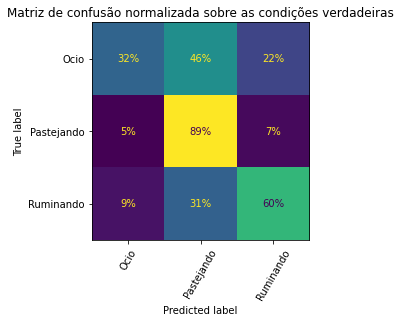

In [28]:
imprimeMatrizDeConfusão(y_test, lgmc_preds, lgmc_model)

In [ ]:
def treinar_modelo(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    
    print(params, '\n')
    
    mdl = LGBMClassifier(learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree, random_state=0, subsample_freq=1, 
                         n_estimators=100)
    mdl.fit(X_train, y_train)
    
    lgmc_preds = lgmc_model.predict(X_test)
    
    return -accuracy_score(y_test, lgmc_preds)*100

space = [(1e-3, 1e-1, 'log-uniform'), #learning rate
         (2, 128), # num_leaves
         (1, 100), # min_child_samples
         (0.05, 1.0), # subsample
         (0.1, 1.0)] # colsample bytree

In [33]:
from skopt import dummy_minimize
resultado = dummy_minimize(treinar_modelo, space, random_state=0, verbose=1, n_calls=30)

In [ ]:
from skopt import gp_minimize
resultados_gp = gp_minimize(treinar_modelo, space, random_state=0, verbose=1, n_calls=30, n_random_starts=10)

### Random Forest

In [292]:
from sklearn.ensemble import RandomForestClassifier

#### Com Randomized Search CV

In [321]:
rf_Model = RandomForestClassifier(random_state=0, n_jobs=-1)

In [322]:
# Create the param grid
rf_param_grid = {'n_estimators':  np.arange(50, 250, 50),
               'max_features': ['auto', 'sqrt'],
               'max_depth':[50, 100, 150, None],
               'criterion': ['gini', 'entropy'],
               'min_samples_split': [2, 5, 10, 30, 50],
               'min_samples_leaf': [1, 2],
               'bootstrap': [True, False]}

In [323]:
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = rf_param_grid, cv = 3, verbose=1, random_state=0)

In [ ]:
%%time
rf_RandomGrid.fit(X_train, y_train)

In [ ]:
rf_RandomGrid.best_params_

{'n_estimators': 150,
 'min_samples_split': 30,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'criterion': 'entropy',
 'bootstrap': False}

In [ ]:
rf_RandomGrid.best_score_

0.7248018384137745

In [ ]:
preds_rf_RG = rf_RandomGrid.predict(X_test)

In [ ]:
accuracy_score(y_test, preds_rf_RG)*100

72.97409023264096

In [ ]:
imprimeMatrizDeConfusão(y_test, preds_rf_RG, rf_RandomGrid)

#### RF com os melhores parâmetros

In [ ]:
model = RandomForestClassifier(n_estimators=150,
                              min_samples_split=30,
                              min_samples_leaf=1,
                              max_features='sqrt',
                              max_depth=100,
                              criterion='entropy',
                              bootstrap=False,
                              n_jobs=-1,
                              random_state=0)
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [ ]:
accuracy_score(y_test, preds)*100

In [ ]:
imprimeMatrizDeConfusão(y_test, preds, model)

### Gradient Boosting

In [29]:
from xgboost import XGBClassifier
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

y_train_ordinal = ordinal_encoder.fit_transform(y_train.array.reshape(-1,1))

xgb_model = XGBClassifier(use_label_encoder=False, random_state=0)
xgb_model.fit(X_train, y_train_ordinal)

[12:36:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [30]:
xgb_preds = xgb_model.predict(X_test)
xgb_preds = ordinal_encoder.inverse_transform(xgb_preds.reshape(-1,1))
accuracy_score(y_test, xgb_preds)

0.70711278444142

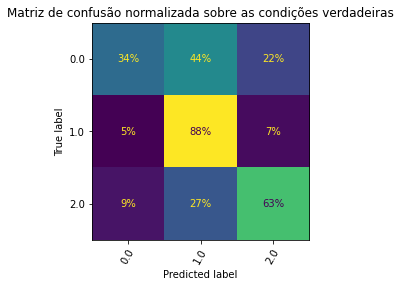

In [31]:
imprimeMatrizDeConfusão(y_test, xgb_preds, xgb_model)

### SVM

In [21]:
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, random_state = 0)

In [ ]:
%%time
svc_model = SVC(kernel='linear', cache_size=5000, random_state=0) # Linear Kernel

svc_model.fit(X_train, y_train)

svc_preds = svc_model.predict(X_test)

In [ ]:
print("Acurácia:", accuracy_score(y_test, svc_preds))

###  Gaussian Naive Bayes

In [18]:
# Conjunto com todas as classes
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [19]:
from sklearn.naive_bayes import GaussianNB

In [20]:
gnb_model = GaussianNB()
gnb_preds = gnb_model.fit(X_train, y_train).predict(X_test)
print("Acurácia:", accuracy_score(y_test, gnb_preds))

Acurácia: 0.5244470166244801


### Logistic Regression

In [38]:
# Conjunto de dados PNP: Pastejando x Não Pastejando
y_pnp = y
y_pnp = y_pnp.replace(to_replace=['Agua', 'Locomovendo', 'Ocio', 'Outros','Ruminando'], value='Não Pastejando')
X_train, X_test, y_train, y_test = train_test_split(X, y_pnp, random_state = 0)

In [23]:
from sklearn.linear_model import LogisticRegression

In [40]:
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [41]:
lr_preds = lr_model.predict(X_test)

In [42]:
print("Acurácia:", accuracy_score(y_test, lr_preds))

Acurácia: 0.6207341736730307


### Redes Neurais

In [24]:
from sklearn.neural_network import MLPClassifier

In [18]:
rn_model = MLPClassifier(early_stopping=True, max_iter=400, random_state=0)
rn_model.fit(X_train, y_train)

MLPClassifier(early_stopping=True, max_iter=400, random_state=0)

In [19]:
rn_preds = rn_model.predict(X_test)

In [20]:
print("Acurácia:", accuracy_score(y_test, rn_preds))

Acurácia: 0.6549561810758213


### KNN

In [33]:
from sklearn.neighbors import KNeighborsClassifier

In [34]:
knn_model = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=10)

In [35]:
knn_preds = knn_model.predict(X_test)

print("Acurácia:", accuracy_score(y_test, knn_preds))

Acurácia: 0.7784568615729022


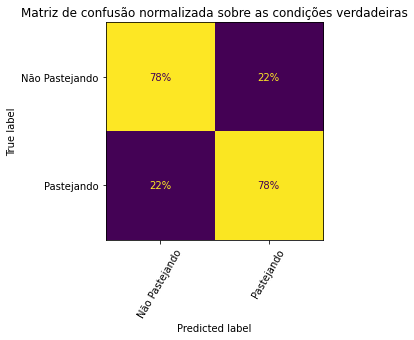

In [36]:
imprimeMatrizDeConfusão(y_test, knn_preds, knn_model)

In [49]:
knn_preds = knn_model.predict(X_test)

print("Acurácia:", accuracy_score(y_test, knn_preds))

Acurácia: 0.7159656062783806


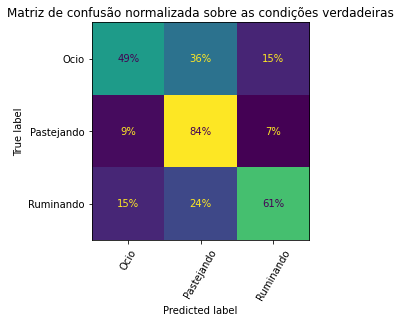

In [45]:
imprimeMatrizDeConfusão(y_test, knn_preds, knn_model)

### Teste de RF em CV

In [22]:
from sklearn.model_selection import cross_val_score

def get_score(n_estimators):
    clf = RandomForestClassifier(n_estimators, random_state=0, n_jobs=-1)
    scores = cross_val_score(clf, X_train, y_train, cv=3)
    return scores.mean()


In [14]:
results = {} 
n_estimators = 100
while n_estimators < 250:
    n_estimators += 50
    results[n_estimators] = get_score(n_estimators)

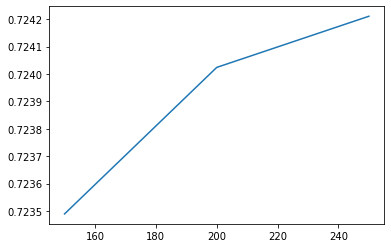

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

### Leave One Group Out

In [25]:
from sklearn.model_selection import LeaveOneGroupOut

In [24]:
df = pd.read_csv(caminho_dados_lazaro)

#### Leave One Animal Out

In [25]:
groups = np.array(df.Animal.values)

In [26]:
loao = LeaveOneGroupOut()
loao.get_n_splits(X, y, groups)

9

In [27]:
df = df[features_aplicaveis]

y = df.Comportamento
X = df.drop('Comportamento', axis=1)

X = np.array(X)
y = np.array(y)

In [28]:
cv = loao.split(X, y, groups)
model = RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=0)
scores = np.array

In [138]:
%%time
for train_index, test_index in cv:
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    model.fit(X_train, y_train.ravel())
    preds = model.predict(X_test)
    scores.append(accuracy_score(y_test, preds)*100)

CPU times: user 19min 26s, sys: 7.76 s, total: 19min 34s
Wall time: 5min 12s


In [143]:
scores.mean()

49.57656849471909

##### Vizualização

In [26]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
y = enc.fit_transform(y.array.reshape(-1, 1))

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

np.random.seed(0)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

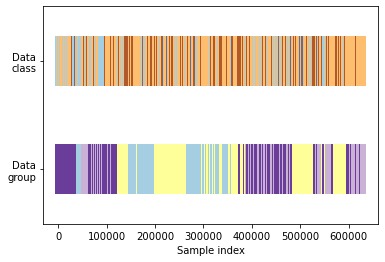

In [108]:
def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )


visualize_groups(y, groups, "no groups")